## Environment set up and import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
with tf.device(device_name):
  print(device_name.split(":")[1]," running . . . ")

In [ ]:
import os,sys
import numpy as np
import random

random.seed(1)
np.random.seed(1)
tf.random.set_seed(2)

In [ ]:
import os, keras, numpy
import matplotlib.pyplot as plt
from numpy import *
from numpy.random import *
from keras.datasets.fashion_mnist import load_data
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import *

## **Discriminator** Model

In [ ]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):

  # input level
  in_label = Input(shape=(1,), name = "input_label")
  li = Embedding(n_classes, 50)(in_label)
  li = Dense(in_shape[0] * in_shape[1])(li)
  li = Reshape((in_shape[0], in_shape[1], 1))(li)

  # input image
  in_image = Input(shape=in_shape, name = "input_image")

  # concate 1
  merge = Concatenate()([in_image, li])

  fe = Conv2D(128, (3,3), strides=(2,2), padding='same', activation = 'relu')(merge)

  # concate 2
  se1 = Embedding(n_classes, 50)(in_label)
  se1 = Dense(14*14, activation='relu')(se1)
  se1 = Reshape((14, 14, 1))(se1)

  merge1 = Concatenate()([fe, se1])

  fe = Conv2D(128, (3,3), strides=(2,2), padding='same', activation = 'relu')(merge1)
  fe = Flatten()(fe)
  fe = Dropout(0.2)(fe)
  
  # final layer
  out_layer = Dense(1, activation='sigmoid')(fe)

  model = Model([in_image, in_label], out_layer)

  opt = Adam(learning_rate= 3e-4, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model
a = define_discriminator()
a.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_label (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 embedding_18 (Embedding)       (None, 1, 50)        500         ['input_label[0][0]']            
                                                                                                  
 dense_36 (Dense)               (None, 1, 784)       39984       ['embedding_18[0][0]']           
                                                                                                  
 input_image (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                           

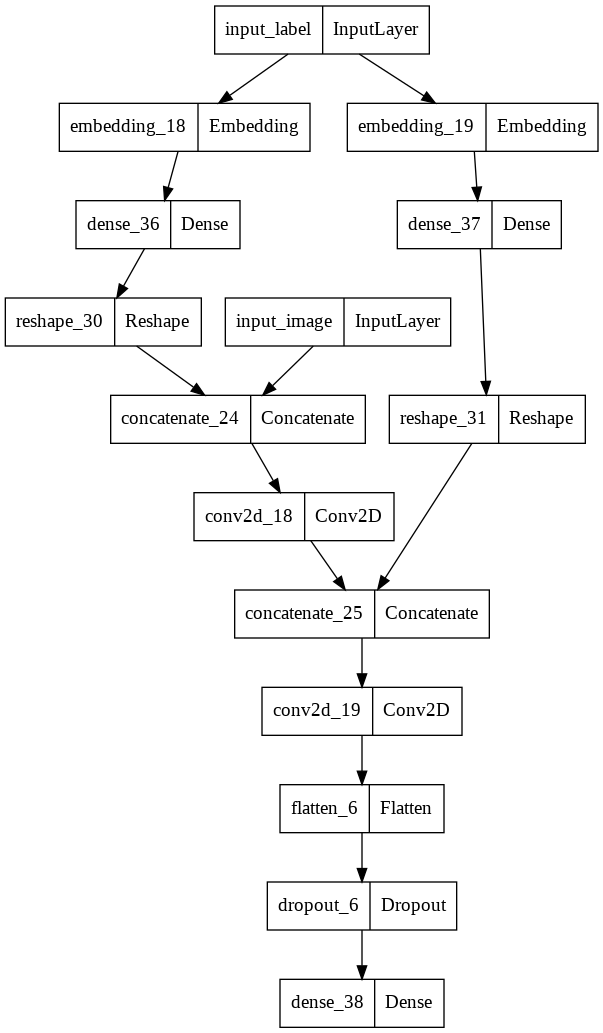

In [ ]:
# plot the discriminator model
tf.keras.utils.plot_model(a)

## **Generator** Model

In [ ]:
def define_generator(latent_dim = 100, n_classes=10):

  # label input
  in_label = Input(shape=(1,), name='in_label')
  li_embedd = Embedding(n_classes, 50)(in_label)
  li = Dense(7 * 7, activation='relu')(li_embedd)
  li = Reshape((7, 7, 1))(li)

  # latent input
  in_latent = Input(shape=(latent_dim,), name='in_latent')

  n_nodes = 128 * 7 * 7
  gen = Dense(n_nodes, activation = 'relu')(in_latent)
  gen = Reshape((7, 7, 128))(gen)

  # concate 1
  merge = Concatenate()([gen, li])

  gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', activation = 'relu')(merge)

  # concate 2
  se1 = Dense(14*14, activation='relu')(li_embedd)
  se1 = Reshape((14, 14, 1))(se1)
  merge1 = Concatenate()([gen, se1])
  gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', activation = 'relu')(merge1)

  # final layer
  out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)

  model = Model([in_latent, in_label], out_layer)
  return model
b = define_generator(100)
b.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_label (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 in_latent (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 embedding_20 (Embedding)       (None, 1, 50)        500         ['in_label[0][0]']               
                                                                                                  
 dense_40 (Dense)               (None, 6272)         633472      ['in_latent[0][0]']              
                                                                                           

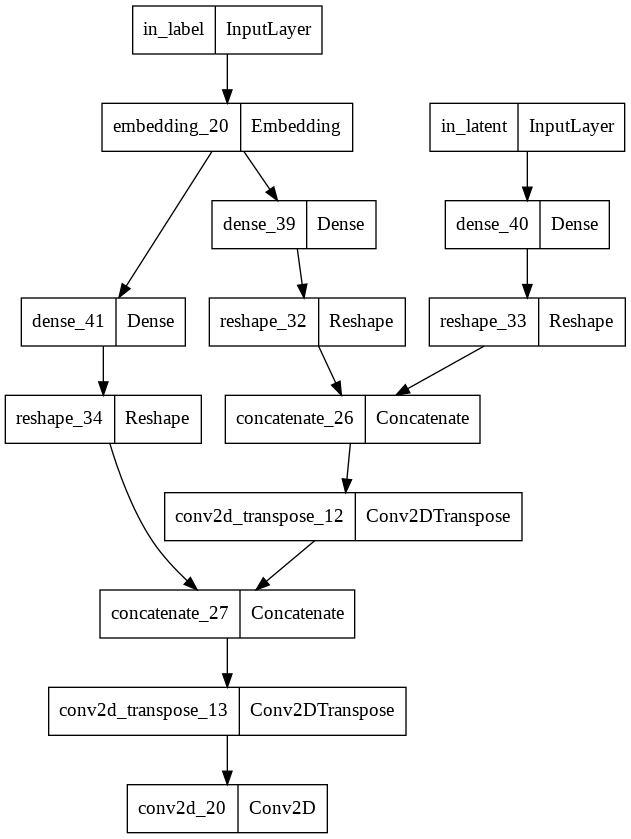

In [ ]:
# plot the generator model
tf.keras.utils.plot_model(b)

## **Combine** or **GAN** Model

In [ ]:
def define_gan(g_model, d_model):

  d_model.trainable = False

  gen_noise, gen_label = g_model.input
  gen_output = g_model.output

  gan_output = d_model([gen_output, gen_label])

  model = Model([gen_noise, gen_label], gan_output)

  opt = Adam(learning_rate= 3e-4, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt,  metrics=['accuracy'])
  
  return model
c = define_gan(b, a)
c.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_label (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 in_latent (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 embedding_20 (Embedding)       (None, 1, 50)        500         ['in_label[0][0]']               
                                                                                                  
 dense_40 (Dense)               (None, 6272)         633472      ['in_latent[0][0]']              
                                                                                           

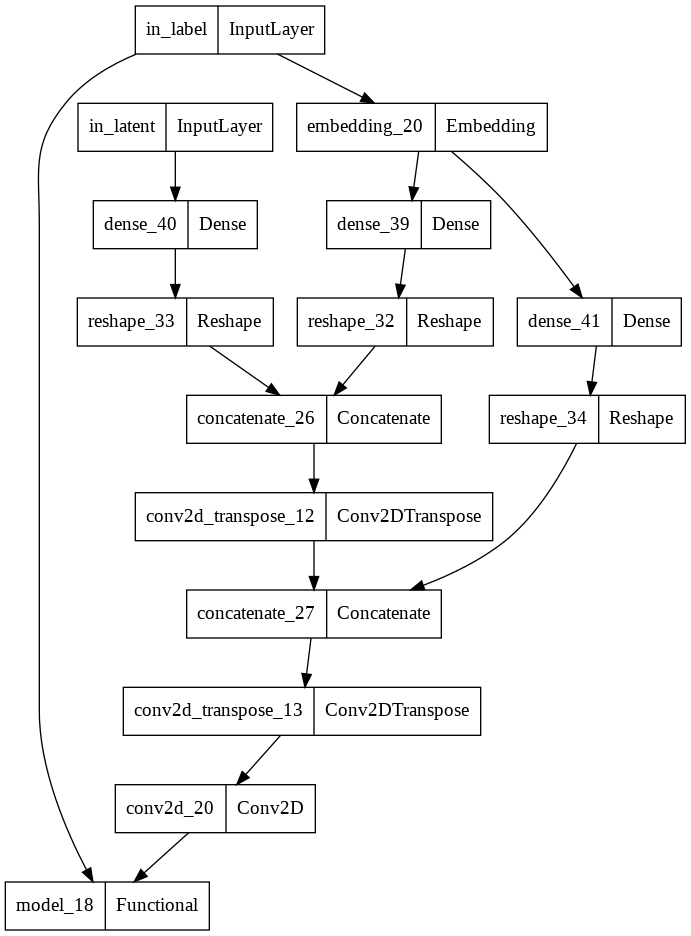

In [ ]:
# plot GAN model
tf.keras.utils.plot_model(c)

## Load Mnist Dataset

In [ ]:
def load_real_samples():
  # load dataset
  (trainX, trainy), (_, _) = mnist.load_data()
  # expand to 3d, e.g. add channels
  X = expand_dims(trainX, axis=-1)
  X = X.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return [X, trainy]
k = load_real_samples()
print("image: ",k[0].shape," Lable: ",k[1].shape)
print("\nshape/size of the first 16 data: ",k[0][:16].shape)

image:  (60000, 28, 28, 1)  Lable:  (60000,)

shape/size of the first 16 data:  (16, 28, 28, 1)


## Plot data with label

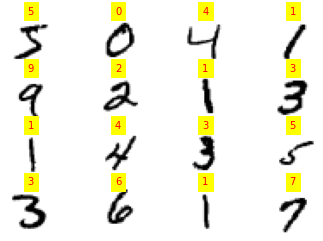

In [ ]:
def save_plot(x_input,lebel,n=4):
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.title(str(lebel[i]),fontsize=10,color="red",fontweight=10,pad='2.0',backgroundcolor='yellow')
        plt.imshow(x_input[i,:,:,0], cmap = 'gray_r')
        plt.axis('off')
    plt.show()
# plot data
save_plot(k[0][:16], k[1][:16])

## Generate real sample function

In [ ]:
def generate_real_samples(dataset, n_samples):
	images, labels = dataset
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	y = ones((n_samples, 1))
	return [X, labels], y
d = generate_real_samples(k, 32)
print("Generate real data as a batch randomly: ",d[0][0].shape)

Generate real data as a batch randomly:  (32, 28, 28, 1)


## Generate latent point function

In [ ]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
  x_input = randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  labels = randint(0, n_classes, n_samples)
  return [z_input, labels]
p = generate_latent_points(100, 32)
print("Generate latent point(with label) as a batch: ",p[0].shape,p[1].shape)

Generate latent point(with label) as a batch:  (32, 100) (32,)


## Generate Fake samples of image with label

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = zeros((n_samples, 1))
	return [images, labels_input], y
with tf.device(device_name):
  kh = generate_fake_samples(b, 100, 32)
  print("shape of the generated images: ",kh[0][0].shape)

shape of the generated images:  (32, 28, 28, 1)


## Summarize the generator model

In [ ]:
def summarize_the_model(generator,latent_dim = 100):
    latent_points, labels = generate_latent_points(latent_dim= 100, n_samples= 16)
    X  = generator.predict([latent_points, labels])
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    save_plot(X, labels, n=4)

## Train function

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim= 100, n_epochs=3, n_batch=128):

  print("No. of epoch: ",n_epochs)
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  print("batch per epoch: ", bat_per_epo)
  half_batch = int(n_batch / 2)
  print("half batch: ", half_batch,'\n')
  print("*"*50,'\n\n')

  d_loss_real_array,d_loss_fake_array =[],[]
  g_loss_array = []
  for i in range(n_epochs):
    d_loss_r,d_loss_f = 0.0,0.0
    g_loss = 0.0
    
    for j in range(bat_per_epo):

      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      d_loss_r += d_loss1

      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
      d_loss_f += d_loss2

      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))
      g_loss1,_ = gan_model.train_on_batch([z_input, labels_input], y_gan)
      g_loss += g_loss1

    d_loss_real_array.append(d_loss_r)
    d_loss_fake_array.append(d_loss_f)
    g_loss_array.append(g_loss)

    print('epoch -> [%d/%d], discriminator_loss_for_real_data = %.2f, discriminator_loss_for_fake_data = %.2f, generator_loss = %.2f\n' %(i+1, n_epochs, d_loss_r, d_loss_f, g_loss))
    summarize_the_model(g_model)
    # g_model.save("g_gan_model_"+str(i)+".h5")
    g_model.save("/content/drive/MyDrive/CGAN_mnist/generator_model.h5")
    np.savez_compressed('/content/drive/MyDrive/CGAN_mnist/loss_record.npz', a=d_loss_real_array, b=d_loss_fake_array, c=g_loss_array)

    print("\n")

  return d_loss_real_array, d_loss_fake_array, g_loss_array

## Main function


READY TO GO !!!

No. of epoch:  200
batch per epoch:  468
half batch:  64 

************************************************** 


epoch -> [1/200], discriminator_loss_for_real_data = 296.23, discriminator_loss_for_fake_data = 311.96, generator_loss = 470.63



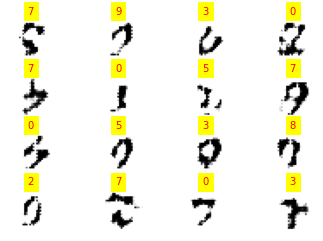



epoch -> [2/200], discriminator_loss_for_real_data = 301.57, discriminator_loss_for_fake_data = 309.92, generator_loss = 370.29



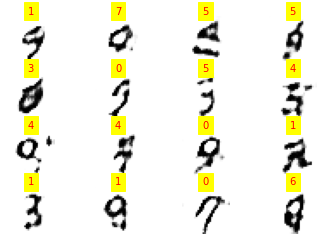



epoch -> [3/200], discriminator_loss_for_real_data = 299.09, discriminator_loss_for_fake_data = 301.95, generator_loss = 393.71



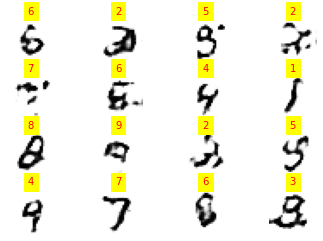



epoch -> [4/200], discriminator_loss_for_real_data = 298.86, discriminator_loss_for_fake_data = 298.33, generator_loss = 394.88



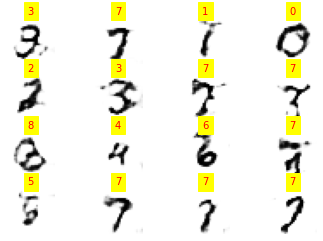



epoch -> [5/200], discriminator_loss_for_real_data = 294.01, discriminator_loss_for_fake_data = 295.96, generator_loss = 407.17



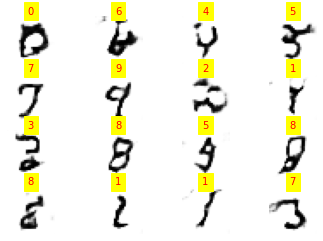



epoch -> [6/200], discriminator_loss_for_real_data = 291.47, discriminator_loss_for_fake_data = 292.17, generator_loss = 421.28



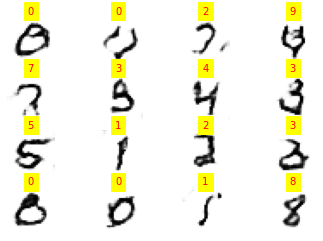



epoch -> [7/200], discriminator_loss_for_real_data = 292.97, discriminator_loss_for_fake_data = 292.52, generator_loss = 420.87



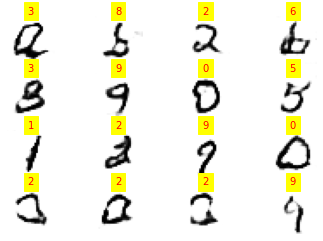



epoch -> [8/200], discriminator_loss_for_real_data = 292.74, discriminator_loss_for_fake_data = 291.15, generator_loss = 423.90



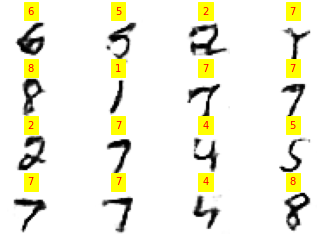



epoch -> [9/200], discriminator_loss_for_real_data = 294.65, discriminator_loss_for_fake_data = 293.05, generator_loss = 424.54



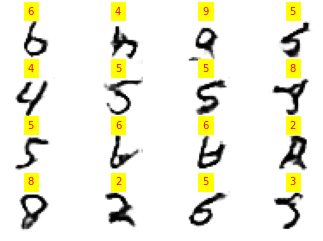



epoch -> [10/200], discriminator_loss_for_real_data = 295.12, discriminator_loss_for_fake_data = 293.25, generator_loss = 427.08



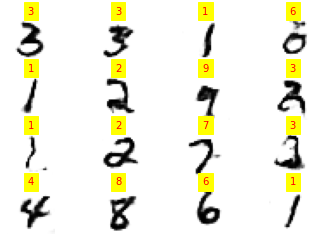



epoch -> [11/200], discriminator_loss_for_real_data = 296.39, discriminator_loss_for_fake_data = 294.54, generator_loss = 423.73



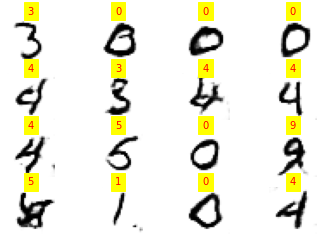



epoch -> [12/200], discriminator_loss_for_real_data = 297.44, discriminator_loss_for_fake_data = 294.68, generator_loss = 422.57



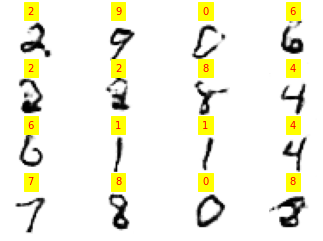



epoch -> [13/200], discriminator_loss_for_real_data = 298.47, discriminator_loss_for_fake_data = 295.35, generator_loss = 422.07



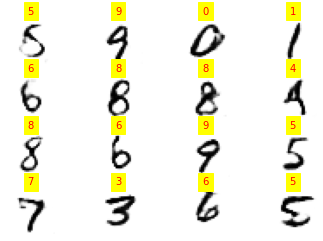



epoch -> [14/200], discriminator_loss_for_real_data = 299.33, discriminator_loss_for_fake_data = 296.67, generator_loss = 421.37



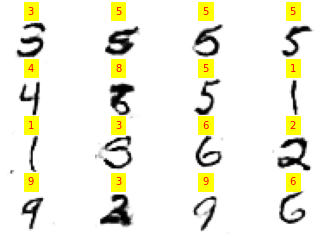



epoch -> [15/200], discriminator_loss_for_real_data = 298.91, discriminator_loss_for_fake_data = 296.21, generator_loss = 424.13



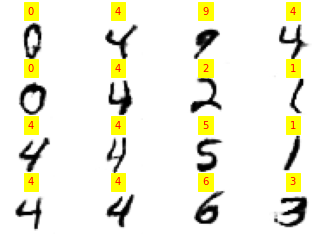



epoch -> [16/200], discriminator_loss_for_real_data = 298.55, discriminator_loss_for_fake_data = 295.52, generator_loss = 419.89



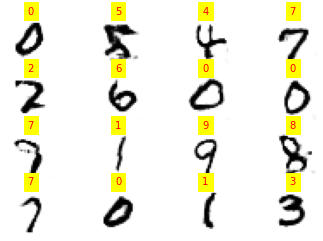



epoch -> [17/200], discriminator_loss_for_real_data = 298.87, discriminator_loss_for_fake_data = 295.76, generator_loss = 422.62



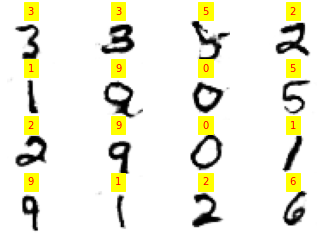



epoch -> [18/200], discriminator_loss_for_real_data = 299.88, discriminator_loss_for_fake_data = 296.29, generator_loss = 424.21



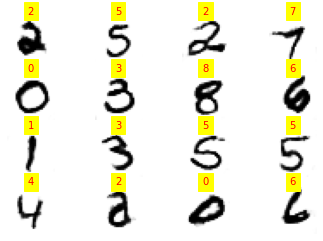



epoch -> [19/200], discriminator_loss_for_real_data = 299.56, discriminator_loss_for_fake_data = 296.20, generator_loss = 422.24



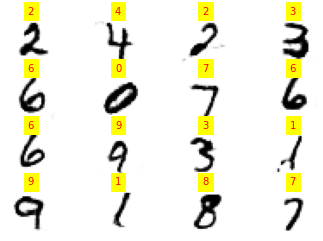



epoch -> [20/200], discriminator_loss_for_real_data = 299.60, discriminator_loss_for_fake_data = 295.85, generator_loss = 425.18



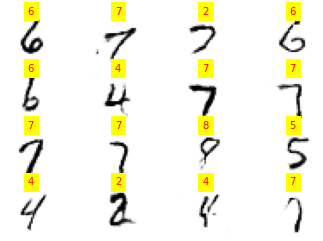



epoch -> [21/200], discriminator_loss_for_real_data = 299.12, discriminator_loss_for_fake_data = 295.74, generator_loss = 426.30



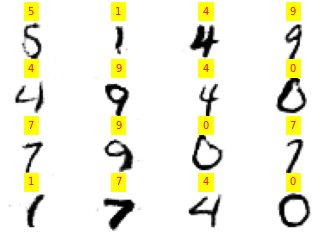



epoch -> [22/200], discriminator_loss_for_real_data = 300.36, discriminator_loss_for_fake_data = 295.83, generator_loss = 426.50



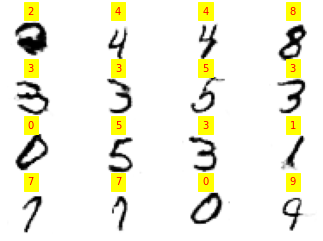



epoch -> [23/200], discriminator_loss_for_real_data = 298.54, discriminator_loss_for_fake_data = 294.19, generator_loss = 430.52



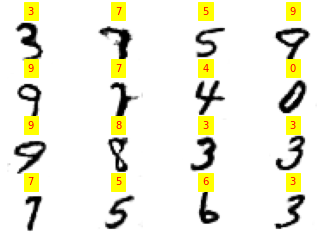



epoch -> [24/200], discriminator_loss_for_real_data = 298.50, discriminator_loss_for_fake_data = 293.38, generator_loss = 433.08



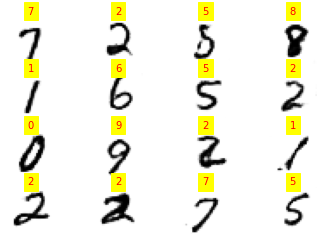



epoch -> [25/200], discriminator_loss_for_real_data = 296.89, discriminator_loss_for_fake_data = 292.25, generator_loss = 434.73



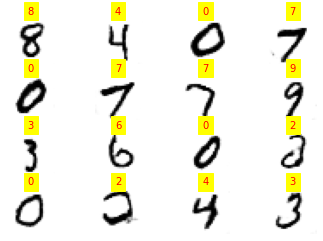



epoch -> [26/200], discriminator_loss_for_real_data = 296.66, discriminator_loss_for_fake_data = 291.12, generator_loss = 438.44



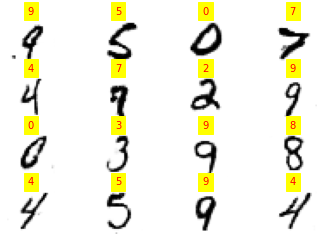



epoch -> [27/200], discriminator_loss_for_real_data = 295.61, discriminator_loss_for_fake_data = 290.08, generator_loss = 438.61



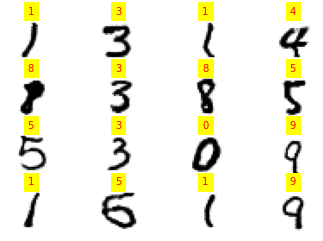



epoch -> [28/200], discriminator_loss_for_real_data = 293.96, discriminator_loss_for_fake_data = 289.39, generator_loss = 443.78



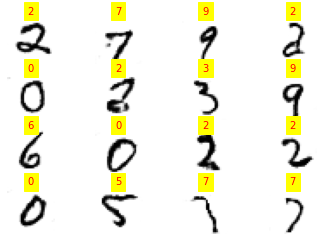



epoch -> [29/200], discriminator_loss_for_real_data = 294.59, discriminator_loss_for_fake_data = 288.46, generator_loss = 446.56



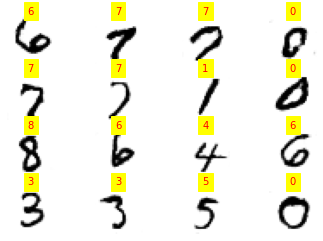



epoch -> [30/200], discriminator_loss_for_real_data = 292.74, discriminator_loss_for_fake_data = 286.56, generator_loss = 448.87



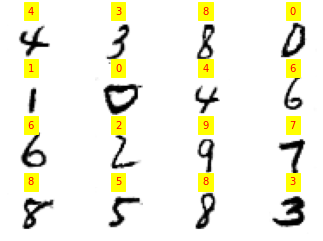



epoch -> [31/200], discriminator_loss_for_real_data = 291.78, discriminator_loss_for_fake_data = 285.03, generator_loss = 455.81



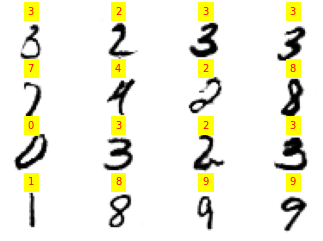



epoch -> [32/200], discriminator_loss_for_real_data = 290.47, discriminator_loss_for_fake_data = 284.22, generator_loss = 459.10



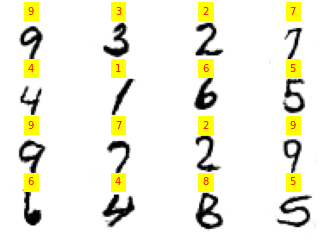



epoch -> [33/200], discriminator_loss_for_real_data = 290.34, discriminator_loss_for_fake_data = 283.12, generator_loss = 462.23



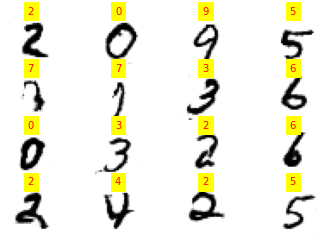



epoch -> [34/200], discriminator_loss_for_real_data = 288.67, discriminator_loss_for_fake_data = 281.85, generator_loss = 464.81



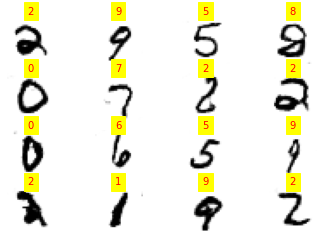



epoch -> [35/200], discriminator_loss_for_real_data = 287.26, discriminator_loss_for_fake_data = 280.02, generator_loss = 471.99



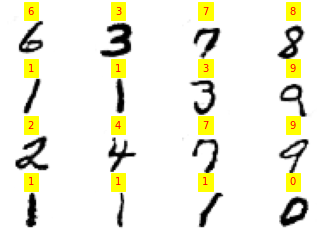



epoch -> [36/200], discriminator_loss_for_real_data = 286.19, discriminator_loss_for_fake_data = 278.69, generator_loss = 473.99



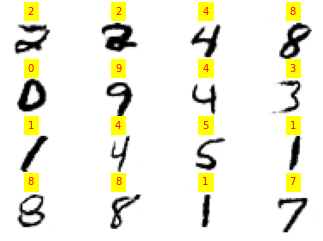



epoch -> [37/200], discriminator_loss_for_real_data = 285.05, discriminator_loss_for_fake_data = 277.19, generator_loss = 479.88



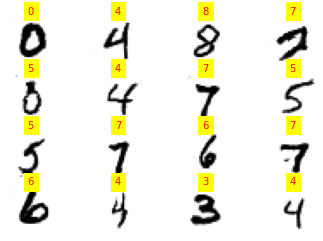



epoch -> [38/200], discriminator_loss_for_real_data = 284.69, discriminator_loss_for_fake_data = 276.71, generator_loss = 482.58



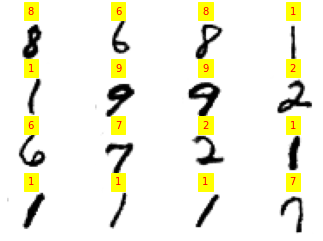



epoch -> [39/200], discriminator_loss_for_real_data = 283.23, discriminator_loss_for_fake_data = 274.79, generator_loss = 487.80



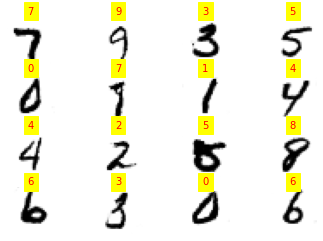



epoch -> [40/200], discriminator_loss_for_real_data = 282.88, discriminator_loss_for_fake_data = 274.70, generator_loss = 489.88



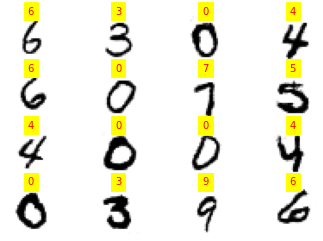



epoch -> [41/200], discriminator_loss_for_real_data = 282.06, discriminator_loss_for_fake_data = 272.53, generator_loss = 494.90



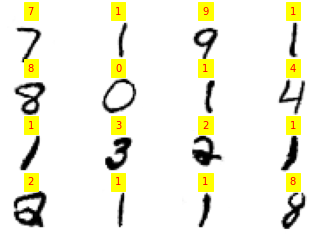



epoch -> [42/200], discriminator_loss_for_real_data = 282.48, discriminator_loss_for_fake_data = 273.15, generator_loss = 493.60



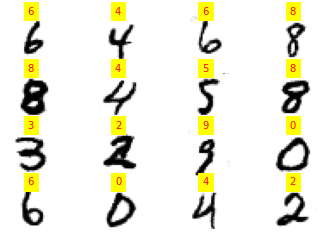



epoch -> [43/200], discriminator_loss_for_real_data = 280.75, discriminator_loss_for_fake_data = 270.62, generator_loss = 500.54



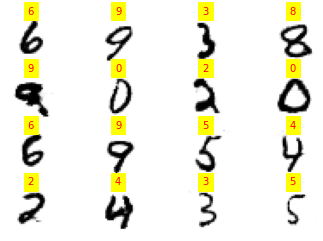



epoch -> [44/200], discriminator_loss_for_real_data = 279.31, discriminator_loss_for_fake_data = 270.16, generator_loss = 502.46



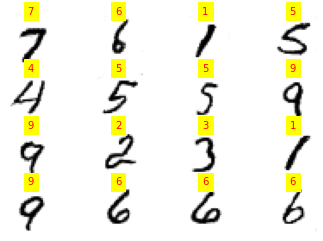



epoch -> [45/200], discriminator_loss_for_real_data = 278.25, discriminator_loss_for_fake_data = 268.04, generator_loss = 507.93



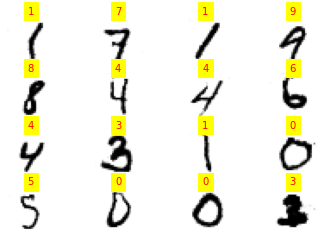



epoch -> [46/200], discriminator_loss_for_real_data = 278.46, discriminator_loss_for_fake_data = 268.80, generator_loss = 510.30



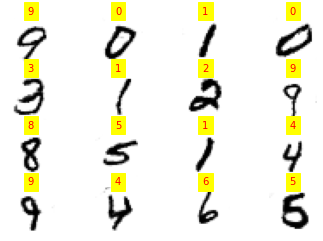



epoch -> [47/200], discriminator_loss_for_real_data = 278.28, discriminator_loss_for_fake_data = 267.62, generator_loss = 509.80



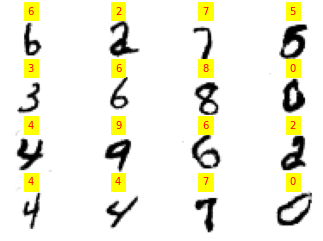



epoch -> [48/200], discriminator_loss_for_real_data = 276.23, discriminator_loss_for_fake_data = 264.93, generator_loss = 515.38



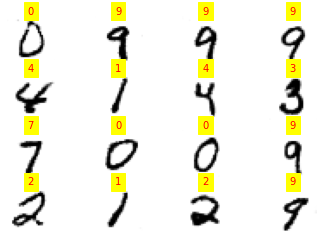



epoch -> [49/200], discriminator_loss_for_real_data = 275.63, discriminator_loss_for_fake_data = 264.37, generator_loss = 517.66



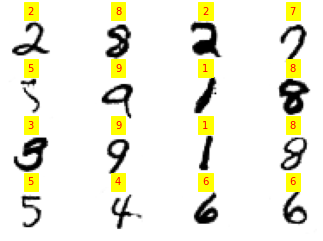



epoch -> [50/200], discriminator_loss_for_real_data = 274.48, discriminator_loss_for_fake_data = 262.43, generator_loss = 523.06



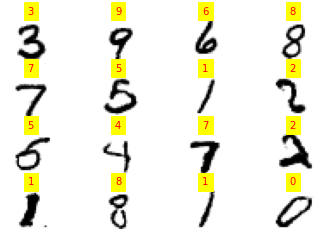



epoch -> [51/200], discriminator_loss_for_real_data = 273.86, discriminator_loss_for_fake_data = 262.81, generator_loss = 524.73



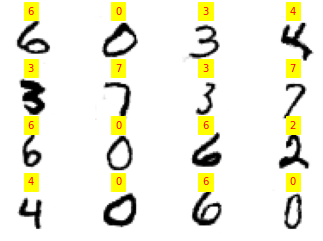



epoch -> [52/200], discriminator_loss_for_real_data = 272.20, discriminator_loss_for_fake_data = 261.19, generator_loss = 530.49



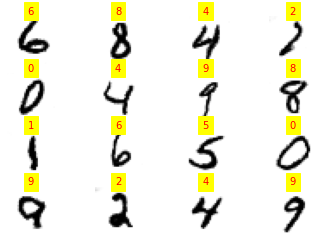



epoch -> [53/200], discriminator_loss_for_real_data = 271.87, discriminator_loss_for_fake_data = 260.31, generator_loss = 531.23



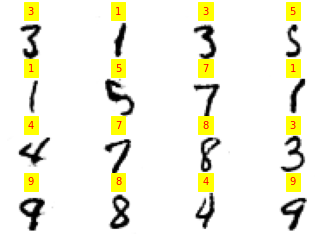



epoch -> [54/200], discriminator_loss_for_real_data = 271.81, discriminator_loss_for_fake_data = 259.60, generator_loss = 531.45



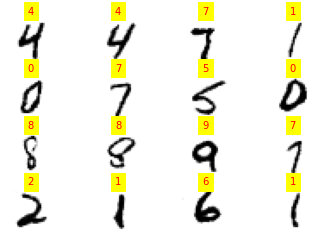



epoch -> [55/200], discriminator_loss_for_real_data = 270.48, discriminator_loss_for_fake_data = 258.65, generator_loss = 535.94



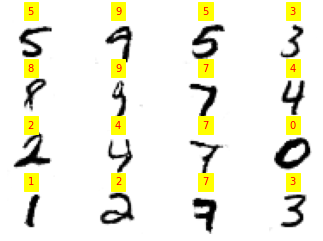



epoch -> [56/200], discriminator_loss_for_real_data = 271.50, discriminator_loss_for_fake_data = 259.43, generator_loss = 531.16



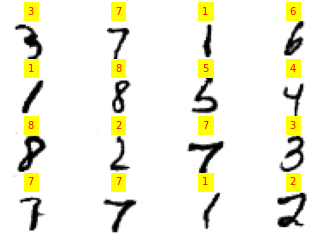



epoch -> [57/200], discriminator_loss_for_real_data = 269.01, discriminator_loss_for_fake_data = 256.75, generator_loss = 540.12



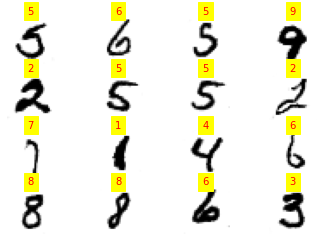



epoch -> [58/200], discriminator_loss_for_real_data = 269.13, discriminator_loss_for_fake_data = 256.32, generator_loss = 543.55



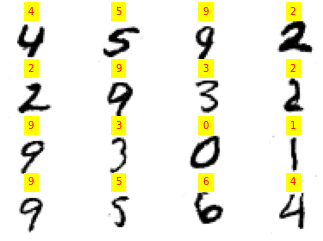



epoch -> [59/200], discriminator_loss_for_real_data = 268.64, discriminator_loss_for_fake_data = 255.33, generator_loss = 542.12



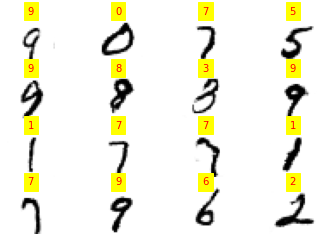



epoch -> [60/200], discriminator_loss_for_real_data = 267.54, discriminator_loss_for_fake_data = 255.30, generator_loss = 543.58



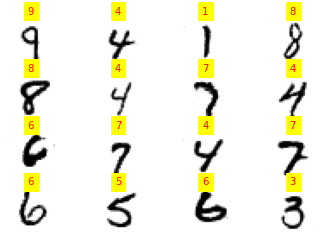



epoch -> [61/200], discriminator_loss_for_real_data = 268.52, discriminator_loss_for_fake_data = 255.94, generator_loss = 542.95



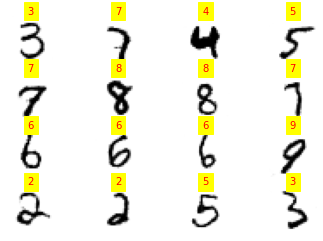



epoch -> [62/200], discriminator_loss_for_real_data = 285.79, discriminator_loss_for_fake_data = 284.47, generator_loss = 490.36



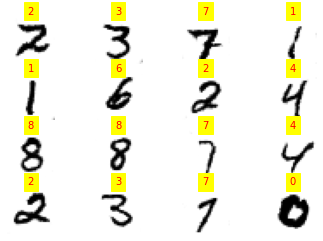



epoch -> [63/200], discriminator_loss_for_real_data = 275.05, discriminator_loss_for_fake_data = 263.02, generator_loss = 526.61



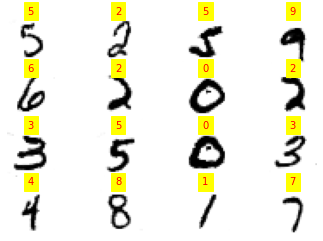



epoch -> [64/200], discriminator_loss_for_real_data = 267.57, discriminator_loss_for_fake_data = 254.29, generator_loss = 550.86



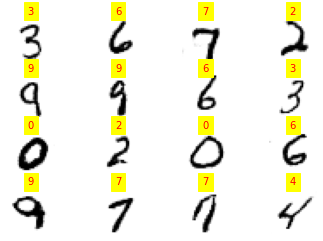



epoch -> [65/200], discriminator_loss_for_real_data = 265.73, discriminator_loss_for_fake_data = 252.33, generator_loss = 555.00



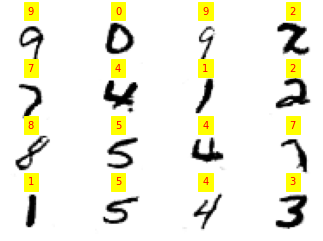



epoch -> [66/200], discriminator_loss_for_real_data = 266.11, discriminator_loss_for_fake_data = 252.38, generator_loss = 555.96



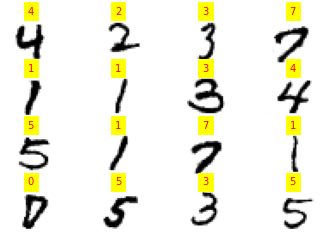



epoch -> [67/200], discriminator_loss_for_real_data = 265.04, discriminator_loss_for_fake_data = 252.01, generator_loss = 560.76



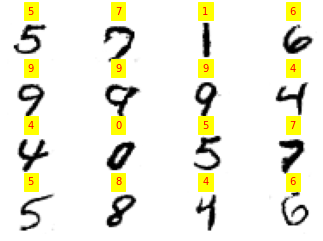



epoch -> [68/200], discriminator_loss_for_real_data = 266.29, discriminator_loss_for_fake_data = 252.63, generator_loss = 554.30



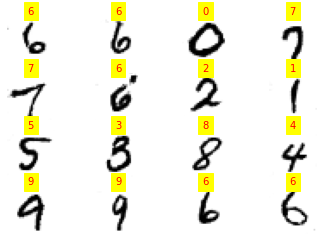



epoch -> [69/200], discriminator_loss_for_real_data = 265.74, discriminator_loss_for_fake_data = 250.85, generator_loss = 558.46



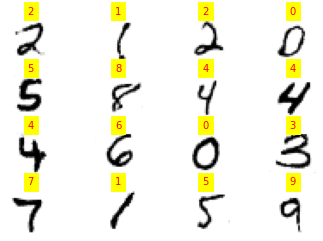



epoch -> [70/200], discriminator_loss_for_real_data = 266.35, discriminator_loss_for_fake_data = 252.35, generator_loss = 555.96



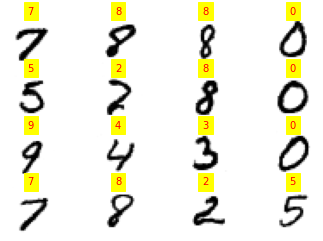



epoch -> [71/200], discriminator_loss_for_real_data = 265.96, discriminator_loss_for_fake_data = 251.73, generator_loss = 557.97



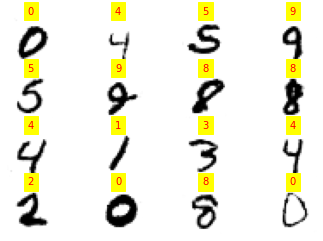



epoch -> [72/200], discriminator_loss_for_real_data = 264.67, discriminator_loss_for_fake_data = 250.52, generator_loss = 559.15



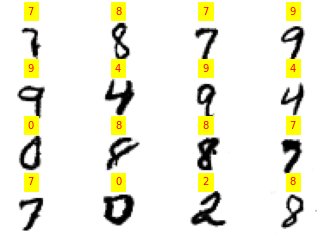



epoch -> [73/200], discriminator_loss_for_real_data = 264.80, discriminator_loss_for_fake_data = 250.16, generator_loss = 562.82



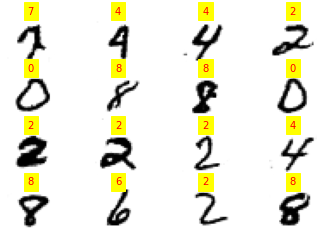



epoch -> [74/200], discriminator_loss_for_real_data = 265.16, discriminator_loss_for_fake_data = 251.21, generator_loss = 561.79



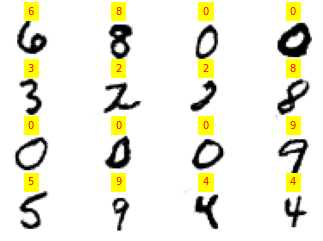



epoch -> [75/200], discriminator_loss_for_real_data = 272.45, discriminator_loss_for_fake_data = 259.17, generator_loss = 532.94



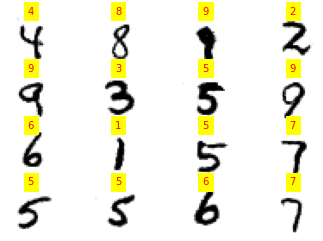



epoch -> [76/200], discriminator_loss_for_real_data = 262.96, discriminator_loss_for_fake_data = 248.84, generator_loss = 568.81



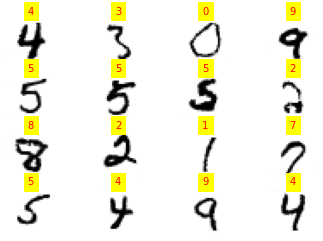



epoch -> [77/200], discriminator_loss_for_real_data = 264.25, discriminator_loss_for_fake_data = 249.33, generator_loss = 564.81



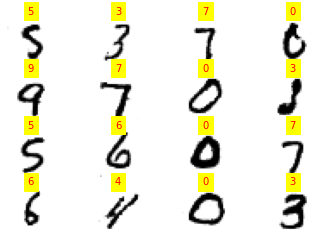



epoch -> [78/200], discriminator_loss_for_real_data = 264.41, discriminator_loss_for_fake_data = 248.18, generator_loss = 566.82



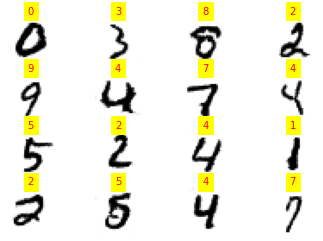



epoch -> [79/200], discriminator_loss_for_real_data = 264.02, discriminator_loss_for_fake_data = 248.09, generator_loss = 570.65



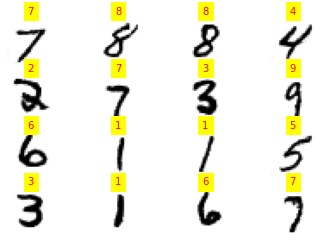



epoch -> [80/200], discriminator_loss_for_real_data = 263.81, discriminator_loss_for_fake_data = 248.68, generator_loss = 571.09



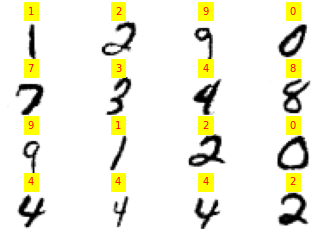



epoch -> [81/200], discriminator_loss_for_real_data = 262.85, discriminator_loss_for_fake_data = 247.49, generator_loss = 570.48



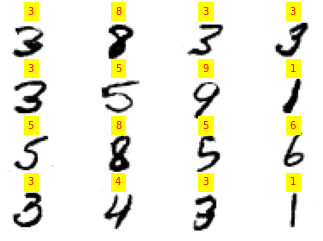



epoch -> [82/200], discriminator_loss_for_real_data = 263.17, discriminator_loss_for_fake_data = 247.28, generator_loss = 566.97



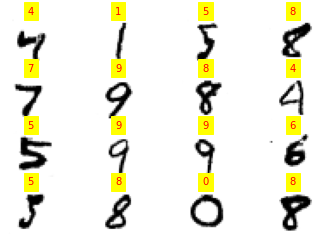



epoch -> [83/200], discriminator_loss_for_real_data = 262.44, discriminator_loss_for_fake_data = 247.06, generator_loss = 570.03



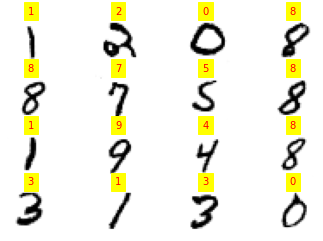



epoch -> [84/200], discriminator_loss_for_real_data = 261.92, discriminator_loss_for_fake_data = 246.32, generator_loss = 571.32



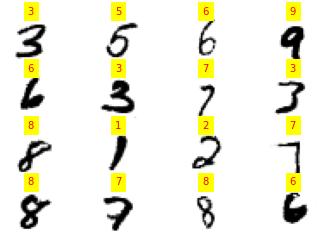



epoch -> [85/200], discriminator_loss_for_real_data = 264.43, discriminator_loss_for_fake_data = 247.83, generator_loss = 568.91



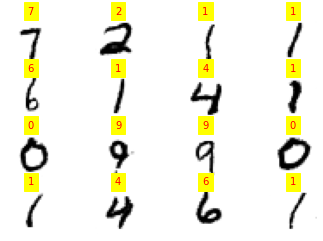



epoch -> [86/200], discriminator_loss_for_real_data = 262.13, discriminator_loss_for_fake_data = 246.23, generator_loss = 569.90



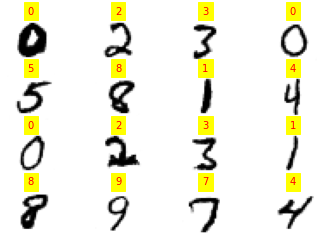



epoch -> [87/200], discriminator_loss_for_real_data = 262.92, discriminator_loss_for_fake_data = 246.59, generator_loss = 573.06



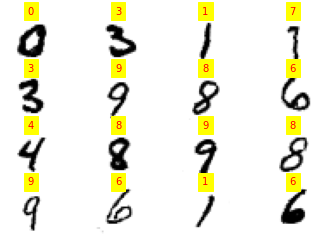



epoch -> [88/200], discriminator_loss_for_real_data = 259.83, discriminator_loss_for_fake_data = 244.09, generator_loss = 570.87



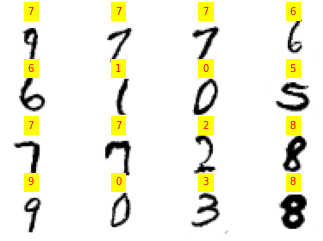



epoch -> [89/200], discriminator_loss_for_real_data = 262.76, discriminator_loss_for_fake_data = 246.32, generator_loss = 573.45



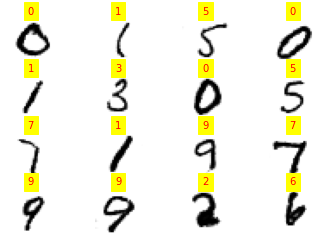



epoch -> [90/200], discriminator_loss_for_real_data = 261.75, discriminator_loss_for_fake_data = 245.76, generator_loss = 570.62



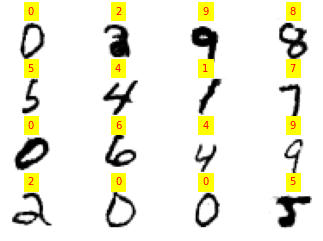



epoch -> [91/200], discriminator_loss_for_real_data = 260.74, discriminator_loss_for_fake_data = 244.95, generator_loss = 574.89



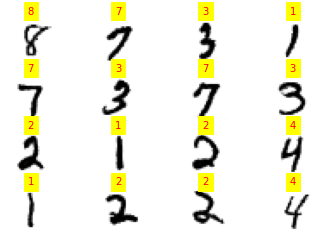

In [ ]:
with tf.device(device_name):

  latent_dim = 100
  n_epochs = 200
  d_model = define_discriminator()
  g_model = define_generator(latent_dim)
  gan_model = define_gan(g_model, d_model)
  dataset = load_real_samples()
  print('\nREADY TO GO !!!\n')
  
  d_loss_r, d_loss_f, g_loss = train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs)

## Plot Loss Values

In [ ]:
loaded = np.load('/content/drive/MyDrive/CGAN_mnist/loss_record.npz')
print(loaded['a'].shape)
print(loaded['b'].shape)
print(loaded['c'].shape)

(92,)
(92,)
(92,)


In [ ]:
import matplotlib.pyplot as plot

g_loss = np.array(loaded['c'])

In [ ]:
d_loss = np.array([(i+j) for i,j in zip(loaded['a'], loaded['b'])])

In [ ]:
# print(d_loss_r)
# print(d_loss_f)
# print(d_loss)
# print(g_loss)

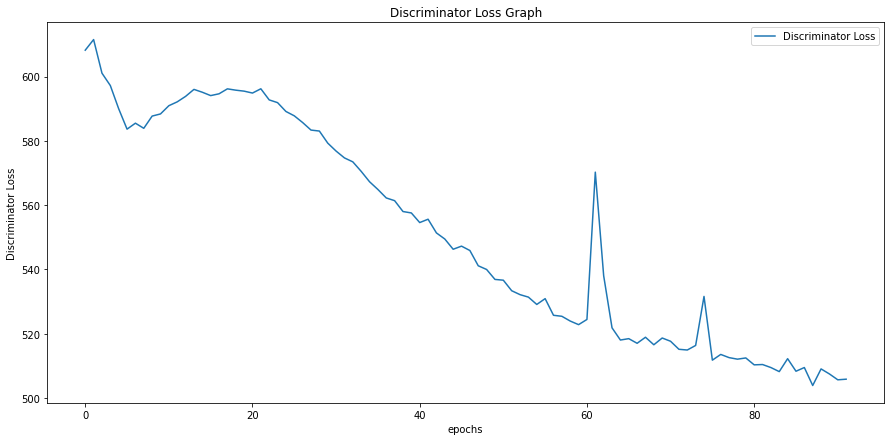

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(d_loss)
plt.title('Discriminator Loss Graph')
plt.ylabel('Discriminator Loss')
plt.xlabel('epochs')
plt.legend(["Discriminator Loss"], loc='upper right')
plt.show()

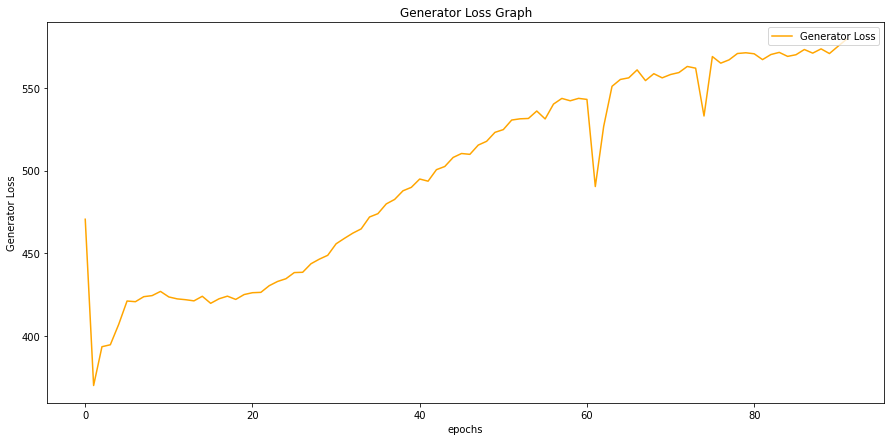

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(g_loss,color='orange')
plt.title('Generator Loss Graph')
plt.ylabel('Generator Loss')
plt.xlabel('epochs')
plt.legend(["Generator Loss"], loc='upper right')
plt.show()

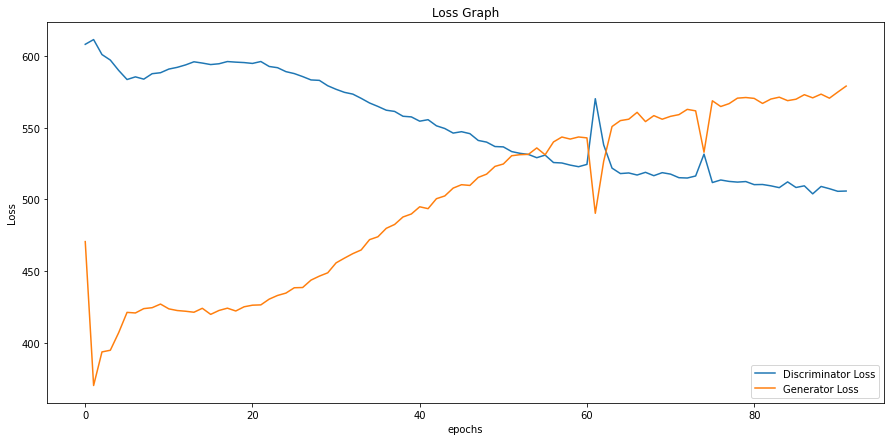

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Loss Graph')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(["Discriminator Loss", "Generator Loss"], loc='lower right')
plt.show()

# Prediction

In [ ]:
latent_dim = 100
n_samples = 16
z_input, labels = generate_latent_points(latent_dim, n_samples)
print("latent points(latent points and labels): ",z_input.shape, labels.shape)
data = [z_input,labels]
pred = g_model.predict(data)
pred = (pred +1 ) / 2.0
print("\nGenerated images with labels: ",pred.shape,'\n')
save_plot(pred,labels,n=4)

                                              -:END:-

In [ ]:
# import numpy as np
# test_array = np.random.rand(3, 2)
# test_vector = np.random.rand(4)
# test_vector_1 = np.random.rand(4,1,4,2)
# np.savez_compressed('ok.npz', a=test_array, b=test_vector, c=test_vector_1)
# loaded = np.load('ok.npz')
# print(loaded['a'].shape)
# print(loaded['b'].shape)
# print(loaded['c'].shape)